In [76]:
import torch
import pickle


import numpy as np 
import pandas as pd
import torch
import tarfile
import glob
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
from torchvision.transforms import functional
import random
from torch.utils.data import Subset
import scipy

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
import numpy as np

# Define the UNet model
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU => Dropout) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_prob=0.5):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, dropout_prob=0.5):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits




In [78]:
model = UNet(n_channels=1, n_classes=4) 

In [79]:
model.load_state_dict(torch.load('Amit_model_weights_t2f.pkl'))  # Load the weights saved in the .pkl file
model.eval()  # Set model to evaluation mode

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.5, inplace=False)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.5, inplace=False)
     

In [ ]:
import nibabel as nib
import torch
import torchvision.transforms as transforms

# Load your NIfTI file (input image)
input_image_path = '/home/sushil/sushil_dataset/deepu/Dataset/Image_Data/Amit_Brats/BraTS2021_Training_Data/training_data1_v2/BraTS-GLI-00009-101/BraTS-GLI-00009-101-t1c.nii.gz'
# Convert the image data to a numpy array
image_data = nib.load(input_image_path).get_fdata()


# The shape should be (depth, height, width), so reshape accordingly
# Convert to tensor and add batch and channel dimensions
image_tensor = torch.tensor(image_data, dtype=torch.float32)

# If your data is 3D, reshape it to (1, 1, depth, height, width) 
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Check the shape of the tensor
print(image_tensor.shape)  # Should print: torch.Size([1, 1, depth, height, width])

# Now pass it to the model
image_tensor = image_tensor.to(device)  

torch.Size([1, 1, 182, 218, 182])


In [81]:
slice_idx = image_data.shape[0] // 2  # Choose the middle slice
image_data_2d = image_data[slice_idx, :, :]  # Select the 2D slice

# Convert the 2D slice to a tensor and add batch and channel dimensions
image_tensor = torch.tensor(image_data_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Check the shape of the tensor
print(image_tensor.shape)  # Should print: torch.Size([1, 1, height, width])

# Now pass it to the model
image_tensor = image_tensor.to(device)  # Move to device (GPU/CPU)

torch.Size([1, 1, 218, 182])


In [82]:
nii_file = '/home/sushil/sushil_dataset/deepu/Dataset/Image_Data/Amit_Brats/BraTS2021_Training_Data/training_data1_v2/BraTS-GLI-00009-101/BraTS-GLI-00009-101-t1c.nii.gz'
img = nib.load(nii_file)

# BRATS dataset usually has 4 modalities: T1, T1c, T2, and T2ce
# The data is a 4D array: (modality, x, y, z)
data = img.get_fdata()

In [83]:
if len(data.shape) == 3:
    # Example: We assume the data is the T2ce modality, if it's the only one in the file
    t2ce_image = data

elif len(data.shape) == 4:
    # If it's 4D (modalities, x, y, z), extract T2ce (usually the 3rd index in 0-based indexing)
    t2ce_image = data[3, :, :, :]  # Adjust index if needed

# Select a 2D slice from the 3D volume (e.g., the middle slice)
slice_idx = t2ce_image.shape[2] // 2
t2ce_slice = t2ce_image[:, :, slice_idx]

# Normalize the slice (optional)
t2ce_slice = (t2ce_slice - np.min(t2ce_slice)) / (np.max(t2ce_slice) - np.min(t2ce_slice))  # Normalize to [0, 1]

In [84]:
from PIL import Image
t2ce_pil = Image.fromarray(t2ce_slice)

# Define the necessary transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization, adjust as needed
])

input_tensor = transform(t2ce_pil).unsqueeze(0)
input_tensor = input_tensor.to(device)

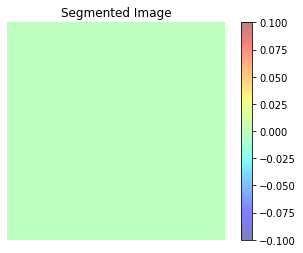

In [44]:
import matplotlib.pyplot as plt


# Example: Assuming 'output' is the model's output with shape (batch_size, num_classes, height, width)
output = output.squeeze(0)  # Remove batch dimension (if present)

# Assuming the output is class probabilities, apply argmax to get the class with the highest probability for each pixel
segmentation_map = torch.argmax(output, dim=0)  # Shape: (height, width)

# Convert to NumPy array for visualization
segmentation_map = segmentation_map.cpu().numpy()  # Ensure the tensor is on CPU

# Plot the segmented result
plt.imshow(segmentation_map, cmap='jet', alpha=0.5)  # Use a suitable colormap for multi-class segmentation
plt.colorbar()  # Display the color bar to indicate class labels
plt.title('Segmented Image')
plt.axis('off')  # Hide axis for better display
plt.show()

In [46]:
output.unique()

tensor([-1.3956, -1.3822, -1.3782,  ...,  1.6891,  1.6988,  1.7020],
       device='cuda:0')

In [57]:
class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.patients = os.listdir(root_dir)[:10] #limiting the loading of dataset to reducing training time as Kaggle have limited GPU
        self.num_slices_per_patient = 155
        self.index_mapping = [
            (patient_id, slice_idx)
            for patient_id in self.patients
            for slice_idx in range(self.num_slices_per_patient)
        ]

    def __len__(self):
        return len(self.index_mapping)

    def __getitem__(self, idx):
        patient_id, slice_idx = self.index_mapping[idx]
        patient_path = os.path.join(self.root_dir, patient_id)
        
        # Loading modalities 
        t1ce_path = os.path.join(patient_path, f"{patient_id}-t1c.nii.gz")
        t1ce_img = nib.load(t1ce_path).get_fdata()
        t1ce_slice = t1ce_img[:, :, slice_idx]
        t1ce_slice = t1ce_slice[np.newaxis, ...] # to create a placeholder for n_channel dimension for model requirement
        
        # Loading segmentation mask
        seg_path = os.path.join(patient_path, f"{patient_id}-seg.nii.gz")
        seg_img = nib.load(seg_path).get_fdata()
        seg_slice = seg_img[:, :, slice_idx]
        
        sample = (t1ce_slice, seg_slice)
        
        if self.transform:
            sample = self.transform(sample)
        
        return t1ce_slice, seg_slice

In [58]:
class Normalize(object):
    """Normalize a tensor image with mean and standard deviation."""
    def __call__(self, sample):
        image, mask = sample
        epsilon = 1e-6
        image = (image - image.mean()) / (image.std() + epsilon)
        return image, mask

class HorizontalFlip(object):
    """Apply horizontal flipping of an image and its mask."""
    def __call__(self, sample):
        image, mask = sample
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=1)
        return image, mask

class RandomRotation(object):
    """Randomly rotate an image and its mask."""
    def __call__(self, sample):
        image, mask = sample
        angle = random.randint(0, 360)  # You can adjust the range of angles
        image = scipy.ndimage.rotate(image, angle, reshape=False)
        mask = scipy.ndimage.rotate(mask, angle, reshape=False)
        return image, mask
    

all_transformation = transforms.Compose([
    Normalize(),
    HorizontalFlip(),
    RandomRotation()
])

Image shape: (182, 218, 182)


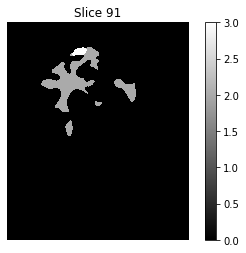

In [89]:
nii_file_path = '/home/sushil/sushil_dataset/deepu/Dataset/Image_Data/Amit_Brats/BraTS2021_Training_Data/training_data1_v2/BraTS-GLI-00020-100/BraTS-GLI-00020-100-seg.nii.gz'  # Provide the path to your NIfTI file
img = nib.load(nii_file_path)

# Get the image data as a NumPy array
data = img.get_fdata()

# Check the shape of the data
print(f"Image shape: {data.shape}")

# Select a 2D slice (e.g., the middle slice along the third axis)
slice_idx = data.shape[2] // 2  # Middle slice
slice_data = data[:, :, slice_idx]

# Display the selected slice
plt.imshow(slice_data.T, cmap='gray')  # Transpose for correct orientation
plt.title(f"Slice {slice_idx}")
plt.colorbar()
plt.axis('off')  # Hide axis
plt.show()


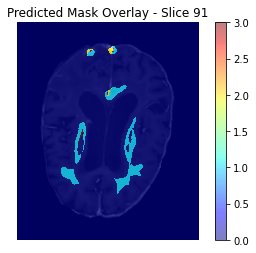

In [91]:
import torch
import nibabel as nib
import matplotlib.pyplot as plt

# Assume `model` is your trained U-Net model
# Move the model to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the correct device

# Example: Load T2ce image from a NIfTI file (replace with your own file path)
nii_file_path = '/home/sushil/sushil_dataset/deepu/Dataset/Image_Data/Amit_Brats/BraTS2021_Training_Data/training_data1_v2/BraTS-GLI-00020-100/BraTS-GLI-00020-100-t1c.nii.gz'  # Provide the path to your NIfTI file
img = nib.load(nii_file_path)
data = img.get_fdata()

# Select a 2D slice from the middle of the 3D image
slice_idx = data.shape[2] // 2  # Middle slice
t2ce_slice = data[:, :, slice_idx]

# Convert the 2D slice to a tensor and add a batch dimension (shape: [1, 1, H, W])
input_tensor = torch.tensor(t2ce_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Move input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Run the model to get the output (predicted mask)
with torch.no_grad():  # No gradient calculation needed for inference
    output = model(input_tensor)  # Model output shape: [1, num_classes, H, W]

# Assuming the output has multiple classes, use argmax to get the predicted class
segmentation_map = torch.argmax(output.squeeze(0), dim=0)  # Shape: [H, W]

# Convert the segmentation map to a NumPy array for visualization
segmentation_map = segmentation_map.cpu().numpy()  # Ensure it's on CPU

# Visualize the predicted mask overlay on the T2ce slice
fig, ax = plt.subplots()
ax.imshow(t2ce_slice.T, cmap='gray')  # Display the original image in grayscale
ax.imshow(segmentation_map.T, cmap='jet', alpha=0.5)  # Overlay the predicted mask with transparency (alpha)
ax.set_title(f"Predicted Mask Overlay - Slice {slice_idx}")
ax.axis('off')  # Hide axis for cleaner view
plt.colorbar(ax.imshow(segmentation_map.T, cmap='jet', alpha=0.5))  # Color bar for segmentation
plt.show()

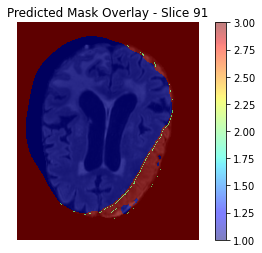

In [87]:
import torch
import nibabel as nib
import matplotlib.pyplot as plt

# Assume `model` is your trained U-Net model
# Move the model to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the correct device

# Example: Load T2ce image from a NIfTI file (replace with your own file path)
nii_file_path = '/home/sushil/sushil_dataset/deepu/Dataset/Image_Data/Amit_Brats/BraTS2021_Training_Data/training_data1_v2/BraTS-GLI-00020-100/BraTS-GLI-00020-100-t2f.nii.gz'  # Provide the path to your NIfTI file
img = nib.load(nii_file_path)
data = img.get_fdata()

# Select a 2D slice from the middle of the 3D image
slice_idx = data.shape[2] // 2  # Middle slice
t2ce_slice = data[:, :, slice_idx]

# Convert the 2D slice to a tensor and add a batch dimension (shape: [1, 1, H, W])
input_tensor = torch.tensor(t2ce_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Move input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Run the model to get the output (predicted mask)
with torch.no_grad():  # No gradient calculation needed for inference
    output = model(input_tensor)  # Model output shape: [1, num_classes, H, W]

# Assuming the output has multiple classes, use argmax to get the predicted class
segmentation_map = torch.argmin(output.squeeze(0), dim=0)  # Shape: [H, W]

# Convert the segmentation map to a NumPy array for visualization
segmentation_map = segmentation_map.cpu().numpy()  # Ensure it's on CPU

# Visualize the predicted mask overlay on the T2ce slice
fig, ax = plt.subplots()
ax.imshow(t2ce_slice.T, cmap='gray')  # Display the original image in grayscale
ax.imshow(segmentation_map.T, cmap='jet', alpha=0.5)  # Overlay the predicted mask with transparency (alpha)
ax.set_title(f"Predicted Mask Overlay - Slice {slice_idx}")
ax.axis('off')  # Hide axis for cleaner view
plt.colorbar(ax.imshow(segmentation_map.T, cmap='jet', alpha=0.5))  # Color bar for segmentation
plt.show()